In [1]:
import os
import zipfile, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
grids = []
grid_dict = {}
        
for folder in sorted(os.listdir('./R403_grids/')):
    if os.path.isfile(f'./R403_grids/{folder}') or folder.startswith('_'):
        continue
    print(folder)
    
    for name in sorted(os.listdir(f'./R403_grids/{folder}/')):
        if name.endswith('.zip') and not name.startswith('__'):
            cord = name[:-4].split('-')[-2:]
            cord = np.array([float(cord[0]), float(cord[1])])

            path = f'./R403_grids/{folder}/{name}'
            with zipfile.ZipFile(path, 'r') as sub_zipfile:

                with sub_zipfile.open('Raw Data.csv', 'r') as csv_file:
                    df = pd.read_csv(csv_file, delimiter=',')

                    row = df.mean()
                    row['cord_x'] = cord[1]
                    row['cord_y'] = cord[0]

                    point = row[['cord_x', 'cord_y', 'Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()
                    grids.append(point)
                    grid_dict[(cord[1], cord[0])] = row[['Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()
grids = np.array(grids)

.ipynb_checkpoints
r012
r10111213
r1415161718
r34567
r89
znew
zthree


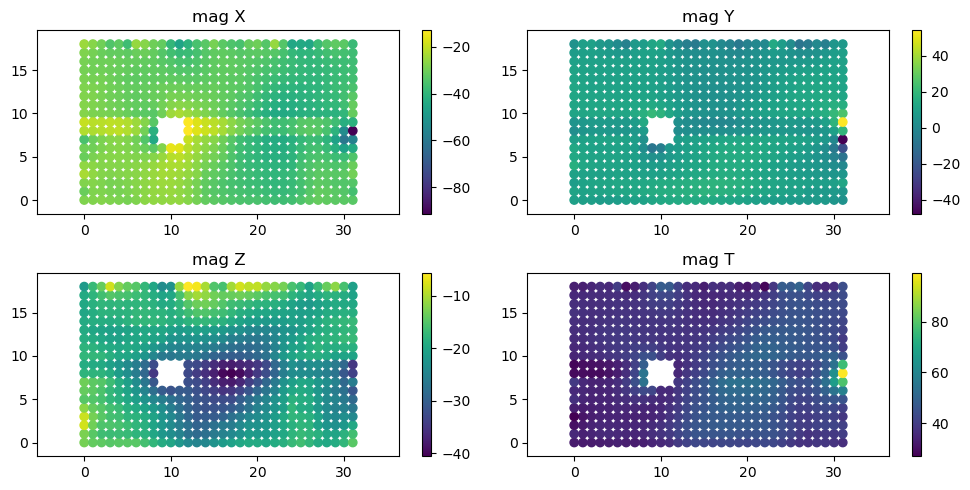

In [56]:
grid_x = grids[:, 0]
grid_y = grids[:, 1]
grid_magX = grids[:, 2]
grid_magY = grids[:, 3]
grid_magZ = grids[:, 4]
grid_magT = grids[:, 5]

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(2, 2, 1)
plt.scatter(grid_x, grid_y, c=grid_magX)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag X')

fig.add_subplot(2, 2, 2)
plt.scatter(grid_x, grid_y, c=grid_magY)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag Y')

fig.add_subplot(2, 2, 3)
plt.scatter(grid_x, grid_y, c=grid_magZ)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag Z')

fig.add_subplot(2, 2, 4)
plt.scatter(grid_x, grid_y, c=grid_magT)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag T')

plt.tight_layout()
plt.show()

壞了 row 8, 9 怪怪的，用 wknn filter 掉吧

In [50]:
grids = np.concatenate((np.array(list(grid_dict.keys())), np.array(list(grid_dict.values()))), axis=-1)
grids.shape

(599, 6)

In [53]:
grids[0]

array([  0.        ,   0.        , -28.11619859,   9.8354764 ,
       -13.00999397,  32.50540471])

In [103]:
def smooth(target_pos, grids, k=2):
    y, x = grids[:, 1], grids[:, 0]
    
    is_neighbor = (target_pos[0] - k < x) & (x < target_pos[0] + k) & (target_pos[1] - k < y) & (y < target_pos[1] + k)
    
    neighbors = grids[is_neighbor]
    distance = np.sqrt(np.sum(np.power(neighbors[:, :2] - target_pos, 2), axis=-1)) + 1e-6
    
#     return np.mean(neighbors[:, 2:], axis=0)

    weights = ((1 / (distance + 0.5)) / np.sum(1 / (distance + 0.5), axis=-1))
    return np.sum(neighbors[:, 2:] * weights[:, None], axis=0)

In [104]:
new_grids = []

for g in grids:
    
    new_g = np.concatenate((g[:2], smooth(g[:2], grids, k=2)))
    new_grids.append(new_g)

new_grids = np.array(new_grids)

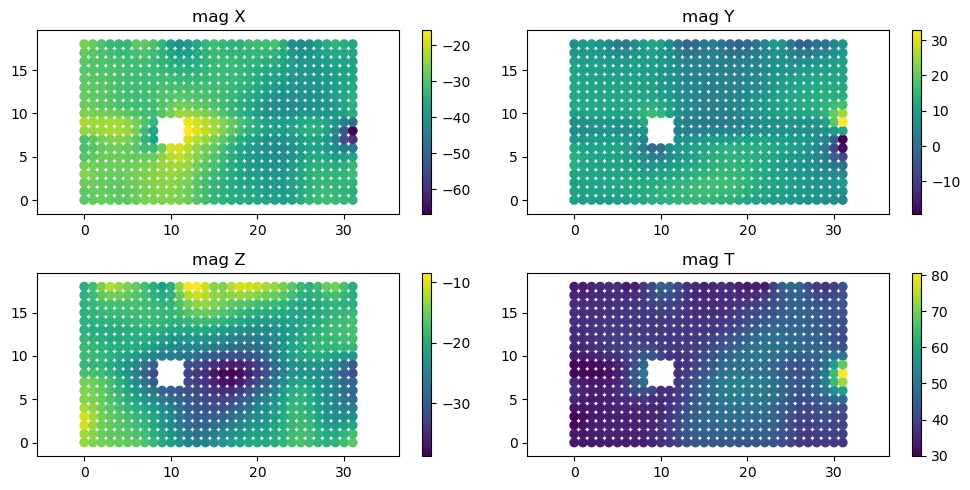

In [106]:
grid_x = new_grids[:, 0]
grid_y = new_grids[:, 1]
grid_magX = new_grids[:, 2]
grid_magY = new_grids[:, 3]
grid_magZ = new_grids[:, 4]
grid_magT = new_grids[:, 5]

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(2, 2, 1)
plt.scatter(grid_x, grid_y, c=grid_magX)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag X')

fig.add_subplot(2, 2, 2)
plt.scatter(grid_x, grid_y, c=grid_magY)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag Y')

fig.add_subplot(2, 2, 3)
plt.scatter(grid_x, grid_y, c=grid_magZ)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag Z')

fig.add_subplot(2, 2, 4)
plt.scatter(grid_x, grid_y, c=grid_magT)
# plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('equal')
plt.title(f'mag T')

plt.tight_layout()
plt.show()

In [107]:
np.save('./grids.npy', new_grids)